## Sample N "valid" CVs

In [1]:
from os import path
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from IPython.display import display, HTML, Audio

from evoclearn.core.samplers import Uniform
from evoclearn.core.utils import KeepLastValue
from evoclearn.core.io import load_bounds_constraints, wav_write
from evoclearn.core import mappings, filters, constraints
from evoclearn.core import vocaltractlab as vtl
from evoclearn.core import definitions as defs

In [2]:
etcdir = path.join("..", "etc")
vtl.initialise(path.join(etcdir, "JD2_speaker.xml"))

<CDLL '/home/demitasse/workspace/evoclearn/evl_core/evoclearn/core/VocalTractLabApi.so', handle 469de20 at 0x7f17580276a0>

In [3]:
speaker_bounds, speaker_constraints = load_bounds_constraints(open(path.join(etcdir, "JD2_bounds.json")))
all_params = list(speaker_bounds)
neutral_values = [speaker_bounds[p]["default"] for p in all_params]
neutral_seq = seq = next(Uniform(speaker_bounds, labels=["C", "V"]))
neutral_seq.loc[:, all_params] = neutral_values

sampled_params = ["HX", "HY", "JA", "JX", "LD", "LP", "TBX", "TBY", "TCX", "TCY", "TS1", "TS2", "TS3", "TTX", "TTY", "VS"]

## Implement the random sampling loop for CV segments

In [4]:
v_duration = [8800 / 44100, 2 * (8800 / 44100)] # 8800 samples ~ 0.2s

#### Set up the simulation pipeline:

In [5]:
speaker_constraints["unclosed_tract_area_thresh"] = 0.1
def consonant_constraint_func(seq):
  return (constraints.consonant_tongue_body_closure(seq, **speaker_constraints)
          or constraints.consonant_tongue_tip_closure(seq, **speaker_constraints)
          or constraints.consonant_lip_closure(seq, **speaker_constraints))

def sample_with_defaults(seq):
  full_seq = neutral_seq.copy()
  full_seq.loc[:, seq.columns] = seq
  return full_seq

add_slope_and_duration = functools.partial(mappings.add_slope_and_duration, durations=v_duration)

sampler = Uniform({k:speaker_bounds[k] for k in sampled_params}, labels=["C", "V"], seed=777)
full_samples = map(sample_with_defaults, sampler)
# valid_samples = KeepLastValue(
#   filters.discard_by_constraints(
#     full_samples, 
#     constraints=[constraints.vowel_voiced, 
#                  functools.partial(constraints.consonant_tongue_body_closure,
#                                    **speaker_constraints)]))
valid_samples = KeepLastValue(
  filters.discard_by_constraints(
    full_samples, constraints=[
      consonant_constraint_func,
      constraints.vowel_voiced
    ]
  )
)
qta_targets = map(add_slope_and_duration, valid_samples)
vtl_curves = map(mappings.target_approximation, qta_targets)
speech_sounds = map(mappings.synthesise_vtl_curves, vtl_curves)

#### Define the simulation loop with stopping criteria, and save updates to files as needed:

In [6]:
five_iterations = itertools.islice(speech_sounds, 5)

targets = []
for i, wav in enumerate(five_iterations):
    print(i)
    wav_write(wav, f"iteration_{str(i).zfill(5)}.wav")
    targets.append(valid_samples.last_value)
    with open(f"iteration_{str(i).zfill(5)}.targets.json", "w") as outf:
      outf.write(valid_samples.last_value.to_json())


0
1
2
3
4


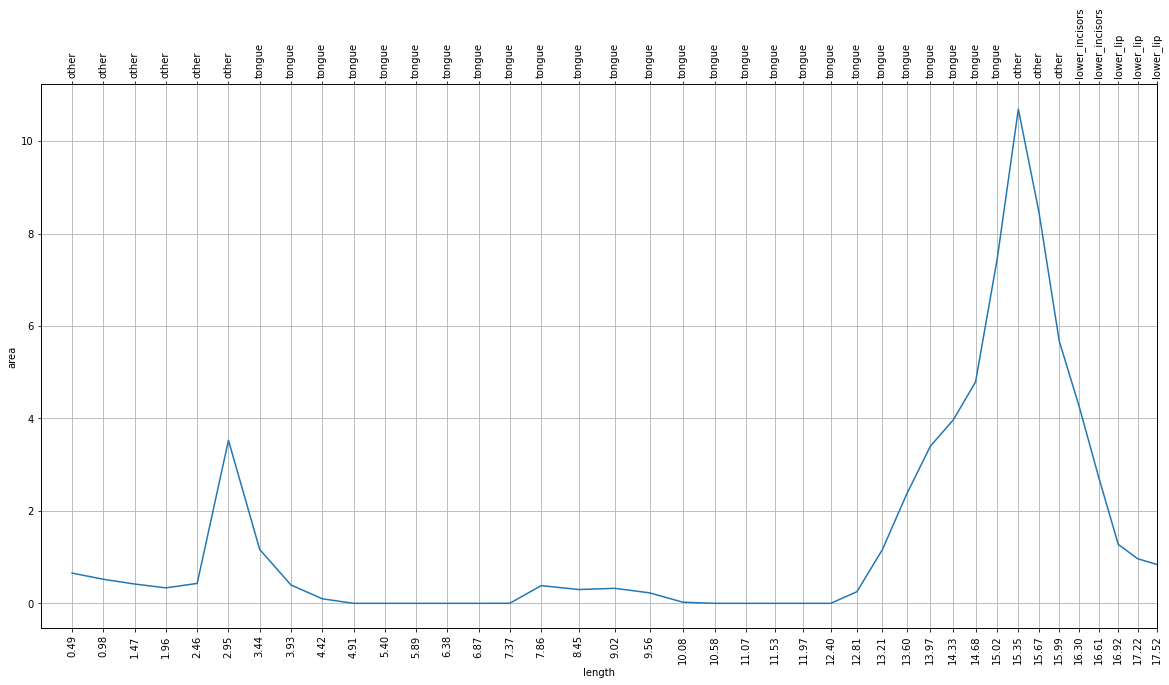

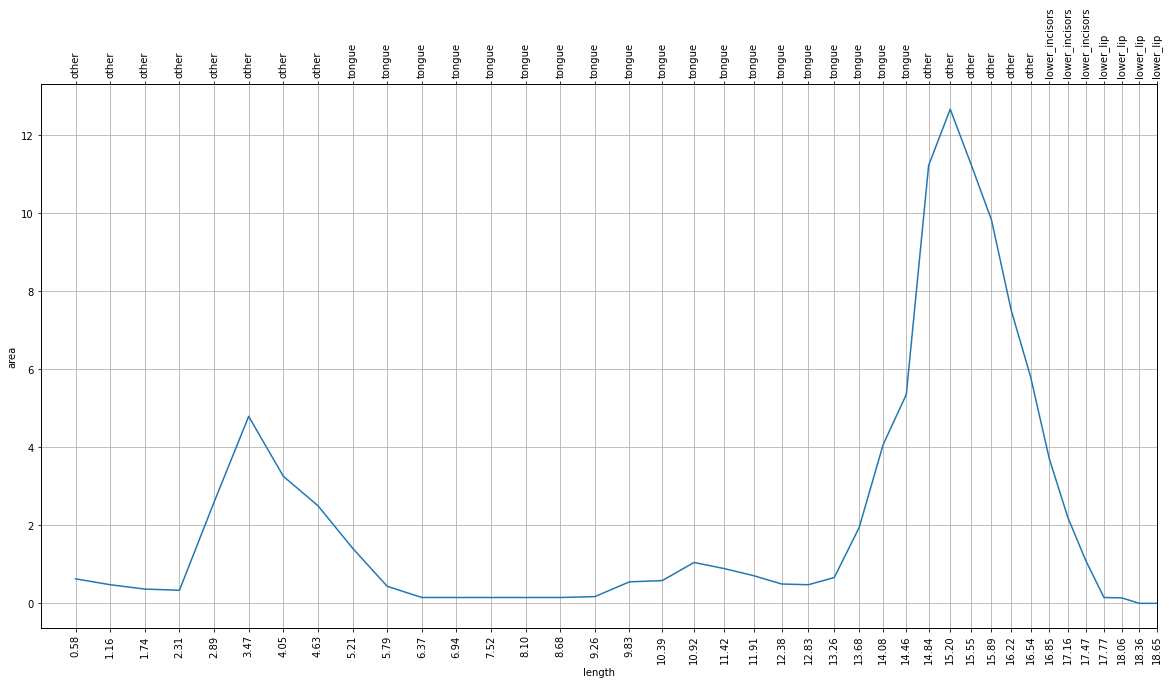

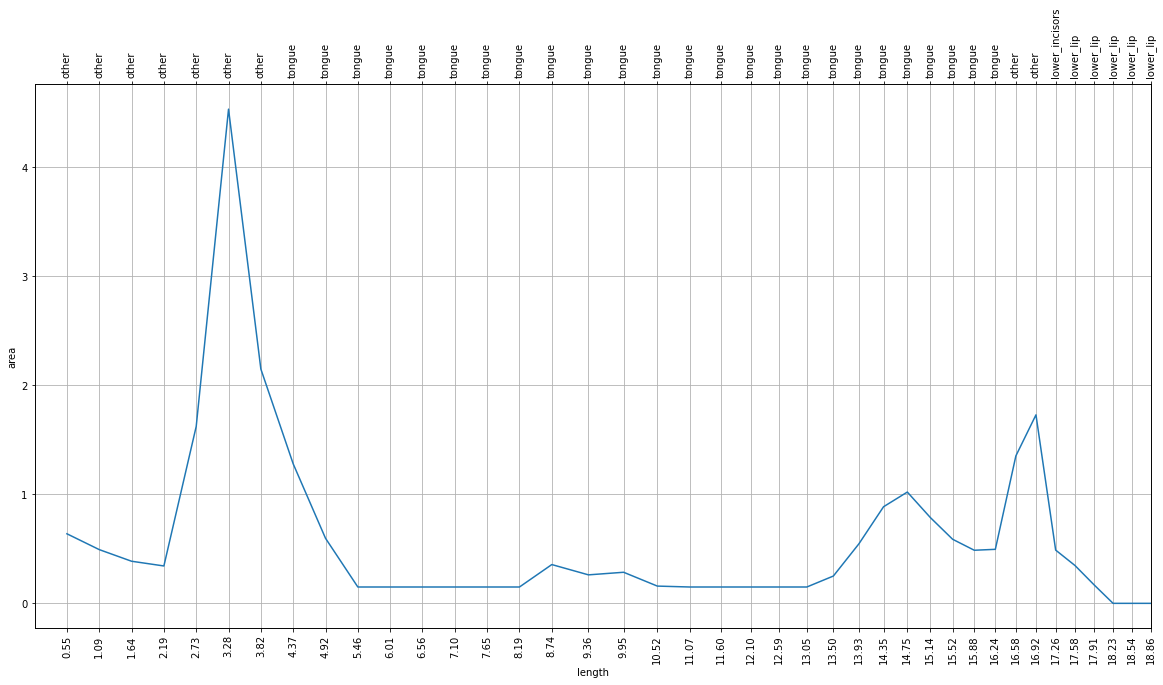

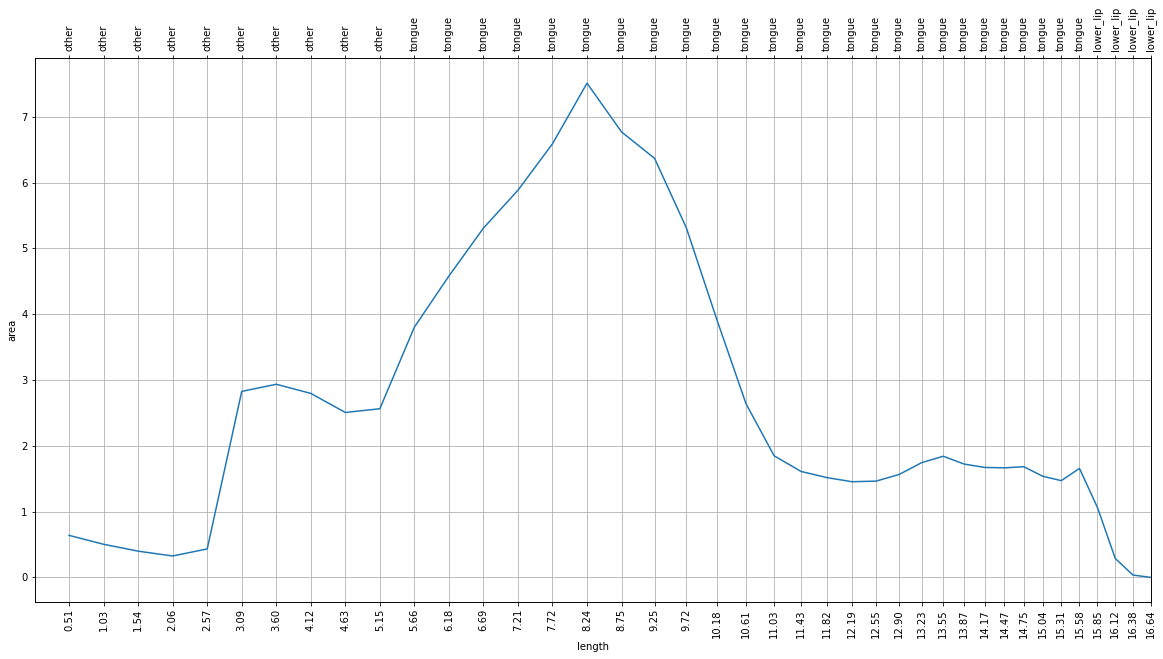

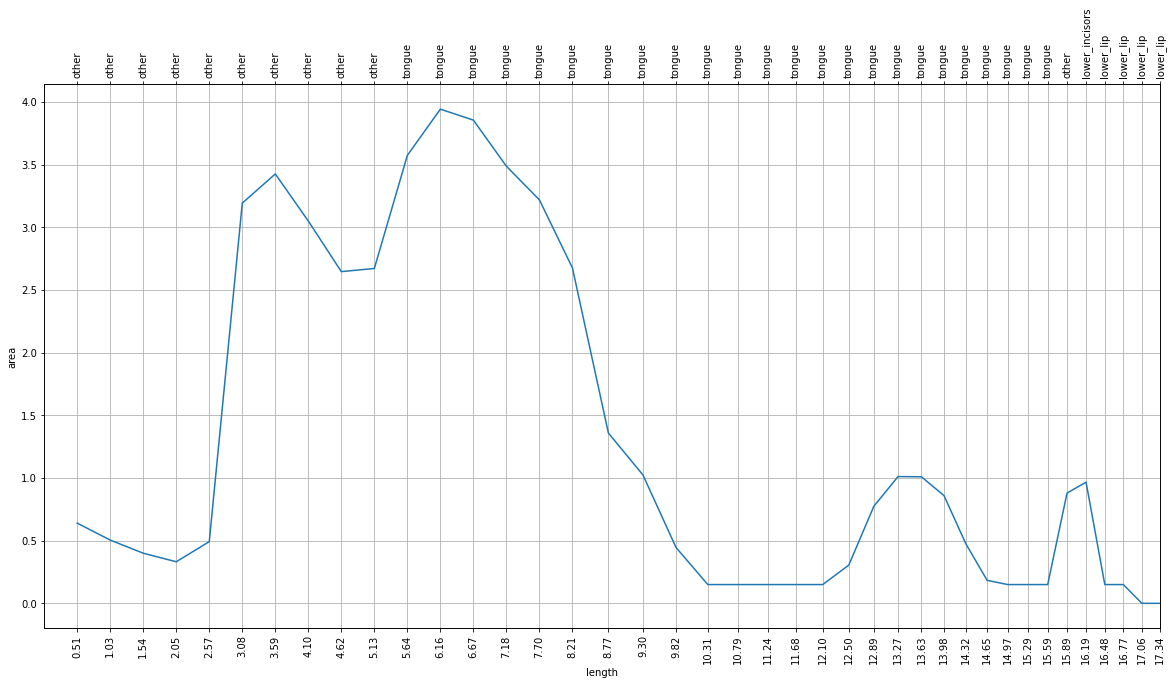

In [7]:
def plot_areas_consonant(seq):
  C_idx = pd.IndexSlice[:, "C"]
  tube = vtl.tube(seq.loc[C_idx, defs.VOCALTRACT_PARAMS])
#   print(tube)
  fig = pl.figure(figsize=(20, 10))
  ax = fig.add_subplot()
  tube_locations = np.cumsum(tube.tubes["tube_length"])
  ax.plot(tube_locations, tube.tubes["tube_area"])
  ax.set_xlim(0.0, tube_locations[-1])
  ax.set_xticks(np.cumsum(tube.tubes["tube_length"]))
  ax.set_xlabel("length")
  ax.set_ylabel("area")
  pl.xticks(rotation=90)
  pl.grid()
  ax2 = ax.twiny()
  ax2.set_xlim(0.0, tube_locations[-1])
  ax2.set_xticks(np.cumsum(tube.tubes["tube_length"]))
  ax2.set_xticklabels([e[1] for e in tube.tubes.index])
  _ = pl.xticks(rotation=90)

for seq in targets:
  plot_areas_consonant(seq)
